# All imports necessary

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys

In [3]:
sys.path.append('..')

In [4]:
import os

In [5]:
import numpy as np

In [7]:
import pandas as pd

In [6]:
from source.code.utils.utils import filter_by_subcorpus
from source.code.utils.utils import get_tagged_texts_as_pd

from source.code.transformers.sentenceextractor import SentenceExtractor
from source.code.models.memorytagger import MemoryTagger
from source.code.models.bilstmtagger import BiLSTMTagger

from source.code.utils.preprocessing import filtrations
from source.code.utils.preprocessing import additional_features
from source.code.utils.preprocessing import crf_pre_processing

Using TensorFlow backend.


In [8]:
from sklearn_crfsuite.metrics import flat_classification_report as crfsuite_classification_report

from sklearn_crfsuite import metrics

from sklearn_crfsuite import CRF as sklearn_crf

In [9]:
from seqeval.metrics import classification_report as seqeval_classification_report

In [11]:
from sklearn.metrics import classification_report as sklearn_classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score

In [10]:
from keras.preprocessing.sequence import pad_sequences

In [12]:
import seaborn as sns

In [15]:
import matplotlib.pyplot as plt

In [14]:
sns.set(color_codes=True)

In [13]:
sns.set(font_scale=2)

In [16]:
%matplotlib inline

In [17]:
features = ['semantic_relation_tagged', 'animacy_tagged', 'lambda_dsr_len', 'word_sense_exists', 'is_title', 'contains_digits', 'word_len']
target = 'ner_tag'

In [18]:
pd.set_option('display.max_rows', 30000)

# Naive tag frequency memorization

## Data reading

In [19]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/', 'subcorpus: Voice of America')

In [20]:
X = get_tagged_texts_as_pd(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

In [21]:
X.ner_tag.value_counts()

O          1032479
geo-nam      55480
org-nam      44646
per-nam      22931
gpe-nam      19685
tim-dow      11398
tim-dat      10929
per-tit       9672
per-fam       8098
[]            4064
tim-moy       3811
tim-yoc       3009
per-giv       2376
tim-clo        810
art-nam        789
eve-nam        514
nat-nam        280
tim-nam        132
eve-ord         63
per-ini         55
per-ord         35
org-leg         13
tim-dom          8
per-mid          1
art-add          1
Name: ner_tag, dtype: int64

In [22]:
X = filtrations(X)

In [23]:
X.ner_tag.value_counts()

O        533756
B-geo     41791
B-org     22916
B-tim     22481
I-per     22429
B-per     20643
I-org     19549
B-gpe     19077
I-geo     13180
I-tim      5603
I-gpe       606
B-art       407
I-art       324
B-eve       310
I-eve       248
B-nat       208
I-nat        72
Name: ner_tag, dtype: int64

In [24]:
X = additional_features(X)

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 723600 entries, 0 to 1231277
Data columns (total 17 columns):
token                       723600 non-null object
pos_tag                     723600 non-null object
lemma                       723600 non-null object
ner_tag                     723600 non-null object
word_net_sense_number       723600 non-null object
verb_net_roles              723600 non-null object
semantic_relation           723600 non-null object
animacy_tag                 723600 non-null object
super_tag                   723600 non-null object
lambda_dsr                  723600 non-null object
semantic_relation_tagged    723600 non-null int64
animacy_tagged              723600 non-null int64
lambda_dsr_len              723600 non-null int64
word_sense_exists           723600 non-null int64
is_title                    723600 non-null int64
contains_digits             723600 non-null int64
word_len                    723600 non-null int64
dtypes: int64(7), object(10)

In [27]:
X, y = X.token, X.ner_tag

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [29]:
estimator = MemoryTagger()

In [30]:
scores = cross_val_score(estimator, X_train, y_train, cv=5, verbose=True, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


In [31]:
scores

array([0.49129128, 0.50843342, 0.50845052, 0.50356955, 0.51533612])

In [32]:
estimator.fit(X_train, y_train)

## Testing

In [33]:
sklearn_report = sklearn_classification_report(y_pred=estimator.predict(X_test), y_true=y_test)
print(sklearn_report)

              precision    recall  f1-score   support

       B-art       0.42      0.16      0.24       134
       B-eve       0.46      0.25      0.32       102
       B-geo       0.72      0.85      0.78     13791
       B-gpe       0.93      0.95      0.94      6295
       B-nat       0.62      0.07      0.13        69
       B-org       0.65      0.52      0.58      7562
       B-per       0.76      0.66      0.71      6812
       B-tim       0.88      0.79      0.83      7419
       I-art       0.23      0.06      0.09       107
       I-eve       0.31      0.12      0.18        82
       I-geo       0.70      0.45      0.55      4349
       I-gpe       0.60      0.17      0.27       200
       I-nat       0.77      0.42      0.54        24
       I-org       0.70      0.57      0.63      6451
       I-per       0.72      0.68      0.70      7402
       I-tim       0.58      0.16      0.25      1849
           O       0.96      0.99      0.97    176140

   micro avg       0.91   

# Random Forest Classifier

## Data reading

In [34]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/', 'subcorpus: Voice of America')

In [121]:
X = get_tagged_texts_as_pd(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

In [36]:
X.ner_tag.value_counts()

O          1032479
geo-nam      55480
org-nam      44646
per-nam      22931
gpe-nam      19685
tim-dow      11398
tim-dat      10929
per-tit       9672
per-fam       8098
[]            4064
tim-moy       3811
tim-yoc       3009
per-giv       2376
tim-clo        810
art-nam        789
eve-nam        514
nat-nam        280
tim-nam        132
eve-ord         63
per-ini         55
per-ord         35
org-leg         13
tim-dom          8
per-mid          1
art-add          1
Name: ner_tag, dtype: int64

In [37]:
X = filtrations(X)

In [38]:
X.ner_tag.value_counts()

O        533756
B-geo     41791
B-org     22916
B-tim     22481
I-per     22429
B-per     20643
I-org     19549
B-gpe     19077
I-geo     13180
I-tim      5603
I-gpe       606
B-art       407
I-art       324
B-eve       310
I-eve       248
B-nat       208
I-nat        72
Name: ner_tag, dtype: int64

In [39]:
X = additional_features(X)

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 723600 entries, 0 to 1231277
Data columns (total 17 columns):
token                       723600 non-null object
pos_tag                     723600 non-null object
lemma                       723600 non-null object
ner_tag                     723600 non-null object
word_net_sense_number       723600 non-null object
verb_net_roles              723600 non-null object
semantic_relation           723600 non-null object
animacy_tag                 723600 non-null object
super_tag                   723600 non-null object
lambda_dsr                  723600 non-null object
semantic_relation_tagged    723600 non-null int64
animacy_tagged              723600 non-null int64
lambda_dsr_len              723600 non-null int64
word_sense_exists           723600 non-null int64
is_title                    723600 non-null int64
contains_digits             723600 non-null int64
word_len                    723600 non-null int64
dtypes: int64(7), object(10)

In [41]:
X, y = X[features], X[target]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [43]:
estimator = RandomForestClassifier()

In [44]:
scores = cross_val_score(estimator, X_train, y_train, cv=5, verbose=True, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.4s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


In [45]:
scores

array([0.87134298, 0.8695419 , 0.87108352, 0.86970647, 0.87065133])

In [46]:
estimator.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Testing

In [47]:
report = sklearn_classification_report(y_pred=estimator.predict(X_test), y_true=y_test)
print(report)

              precision    recall  f1-score   support

       B-art       0.33      0.01      0.01       134
       B-eve       0.67      0.02      0.04       102
       B-geo       0.42      0.77      0.54     13791
       B-gpe       0.97      0.92      0.94      6295
       B-nat       0.08      0.01      0.02        69
       B-org       0.47      0.44      0.45      7562
       B-per       0.50      0.70      0.58      6812
       B-tim       0.86      0.60      0.71      7419
       I-art       0.00      0.00      0.00       107
       I-eve       0.00      0.00      0.00        82
       I-geo       0.40      0.01      0.01      4349
       I-gpe       0.25      0.02      0.04       200
       I-nat       0.00      0.00      0.00        24
       I-org       0.47      0.13      0.21      6451
       I-per       0.54      0.51      0.52      7402
       I-tim       0.74      0.32      0.44      1849
           O       0.99      0.99      0.99    176140

   micro avg       0.87   

# HMM

[Данная статья](https://pdfs.semanticscholar.org/9528/4b31f27b9b8901fdc18554603610ebbc2752.pdf) дает полное описание того, как расчитать параметры скрытой марковской модели.

Из [данной статьи](https://www.digitalvidya.com/blog/inroduction-to-hidden-markov-models-using-python/) взята имплементация алгоритма Витерби.

In [48]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/', 'subcorpus: Voice of America')

In [49]:
X = get_tagged_texts_as_pd(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

In [50]:
X.head(30)

,token,pos_tag,lemma,ner_tag,word_net_sense_number,verb_net_roles,semantic_relation,animacy_tag,super_tag,lambda_dsr
0,Thousands,NNS,thousand,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1001]:pred(v1,thousand,n..."
1,of,IN,of,O,0,[],O,O,(NP\NP)/NP,"lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(..."
2,demonstrators,NNS,demonstrator,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1003]:pred(v1,demonstrat..."
3,have,VBP,have,O,0,[],O,O,(S[dcl]\NP)/(S[pt]\NP),"lam(v1,lam(v2,lam(v3,app(app(v1,v2),lam(v4,mer..."
4,marched,VBN,march,O,1,[Theme],O,O,S[pt]\NP,"lam(v1,lam(v2,app(v1,lam(v3,merge(b1:drs([b1:[..."
5,through,IN,through,O,0,[],O,O,((S[pt]\NP)\(S[pt]\NP))/NP,"lam(v1,lam(v2,lam(v3,lam(v4,app(app(v2,v3),lam..."
6,London,NNP,london,geo-nam,1,[],O,Place,N,"lam(v1,b1:drs([],[b1:[1007]:named(v1,london,ge..."
7,to,TO,to,O,0,[],O,O,(S[to]\NP)/(S[b]\NP),"lam(v1,lam(v2,lam(v3,merge(b1:drs([b1:[1008]:p..."
8,protest,VB,protest,O,1,"[Theme,Agent]",O,O,(S[b]\NP)/NP,"lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(..."
9,the,DT,the,O,0,[],O,O,NP/N,"lam(v1,lam(v2,alfa(def,merge(b1:drs([b1:[1010]..."


In [51]:
X.ner_tag.value_counts()

O          1032479
geo-nam      55480
org-nam      44646
per-nam      22931
gpe-nam      19685
tim-dow      11398
tim-dat      10929
per-tit       9672
per-fam       8098
[]            4064
tim-moy       3811
tim-yoc       3009
per-giv       2376
tim-clo        810
art-nam        789
eve-nam        514
nat-nam        280
tim-nam        132
eve-ord         63
per-ini         55
per-ord         35
org-leg         13
tim-dom          8
per-mid          1
art-add          1
Name: ner_tag, dtype: int64

Проведем охапку фильтраций и переведем тэги в нужный формат:

In [52]:
X = filtrations(X, with_dots=True)

In [53]:
X.head(30)

,token,pos_tag,lemma,ner_tag,word_net_sense_number,verb_net_roles,semantic_relation,animacy_tag,super_tag,lambda_dsr
0,Thousands,NNS,thousand,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1001]:pred(v1,thousand,n..."
2,demonstrators,NNS,demonstrator,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1003]:pred(v1,demonstrat..."
4,marched,VBN,march,O,1,[Theme],O,O,S[pt]\NP,"lam(v1,lam(v2,app(v1,lam(v3,merge(b1:drs([b1:[..."
6,London,NNP,london,B-geo,1,[],O,Place,N,"lam(v1,b1:drs([],[b1:[1007]:named(v1,london,ge..."
8,protest,VB,protest,O,1,"[Theme,Agent]",O,O,(S[b]\NP)/NP,"lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(..."
10,war,NN,war,O,1,[],O,Non-concrete,N,"lam(v1,b1:drs([],[b1:[1011]:pred(v1,war,n,'1')]))"
12,Iraq,NNP,iraq,B-geo,1,[],O,Place,N,"lam(v1,b1:drs([],[b1:[1013]:named(v1,iraq,geo,..."
14,demand,VB,demand,O,1,"[Recipient,Agent]",O,O,(S[b]\NP)/NP,"lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(..."
16,withdrawal,NN,withdrawal,O,1,[],O,Non-concrete,N,"lam(v1,b1:drs([],[b1:[1017]:pred(v1,withdrawal..."
18,British,JJ,uk,B-gpe,0,[],of,Human,N/N,"lam(v1,lam(v2,merge(b1:drs([b1:[]:x1],[b1:[101..."


In [54]:
X.ner_tag.value_counts()

O        590495
B-geo     42533
B-org     23133
B-tim     22603
I-per     22211
B-per     20861
I-org     19332
B-gpe     19106
I-geo     12438
I-tim      5481
I-gpe       577
B-art       409
I-art       322
B-eve       310
I-eve       248
B-nat       208
I-nat        72
Name: ner_tag, dtype: int64

In [55]:
X.ner_tag.nunique()

17

Подход, предложенный в статье, в целом, бьется на три шага:
- Подготовка данных;
- Оценка параметров (обучение);
- Использование модели с обученными параметрами (валидация).

## Step 1: Data preparation

In [56]:
X, y = SentenceExtractor().fit_transform(X)

In [57]:
lemma_sentence_lenghts = list(map(len, X))

In [58]:
tag_sentence_lenghts = list(map(len, y))

In [59]:
max(lemma_sentence_lenghts)

61

In [60]:
max(tag_sentence_lenghts)

61

In [61]:
all(len_lemmas == len_tags for len_lemmas, len_tags in zip(lemma_sentence_lenghts, tag_sentence_lenghts))

True

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Step 2: HMM Parameter Estimation

### Step 2.1: Find states.

In [63]:
states = list(set([tag for sentence in y_train for tag in sentence]))
tag2idx = {t: i for i, t in enumerate(states)}
idx2tag = {i: w for w, i in tag2idx.items()}

In [64]:
len(states)

17

In [65]:
states

['B-art',
 'B-nat',
 'B-geo',
 'B-org',
 'I-nat',
 'I-per',
 'I-art',
 'O',
 'I-org',
 'B-tim',
 'B-eve',
 'I-tim',
 'I-geo',
 'I-eve',
 'B-gpe',
 'I-gpe',
 'B-per']

### Step 2.2: Calculate Start probability (π)

In [66]:
pi = np.zeros(len(states))

In [67]:
for sentence in y_train:
    if len(sentence) > 0:
        pi[tag2idx[sentence[0]]] += 1

In [68]:
pi = pi / len(y_train)

### Step 2.3: Calculate transition probability (A)

In [69]:
A = np.zeros((len(states), len(states)))
A_i = np.zeros(len(states))

In [70]:
for i in range(len(y_train)):
    if len(y_train[i]) > 1:
        for j in range(len(y_train[i]) - 1):
            A[tag2idx[y_train[i][j]]][tag2idx[y_train[i][j + 1]]] += 1
            A_i[tag2idx[y_train[i][j]]] += 1
        A_i[tag2idx[y_train[i][len(y_train[i]) - 1]]] += 1
for i in range(len(states)):
    A[i] = A[i] / A_i[i]

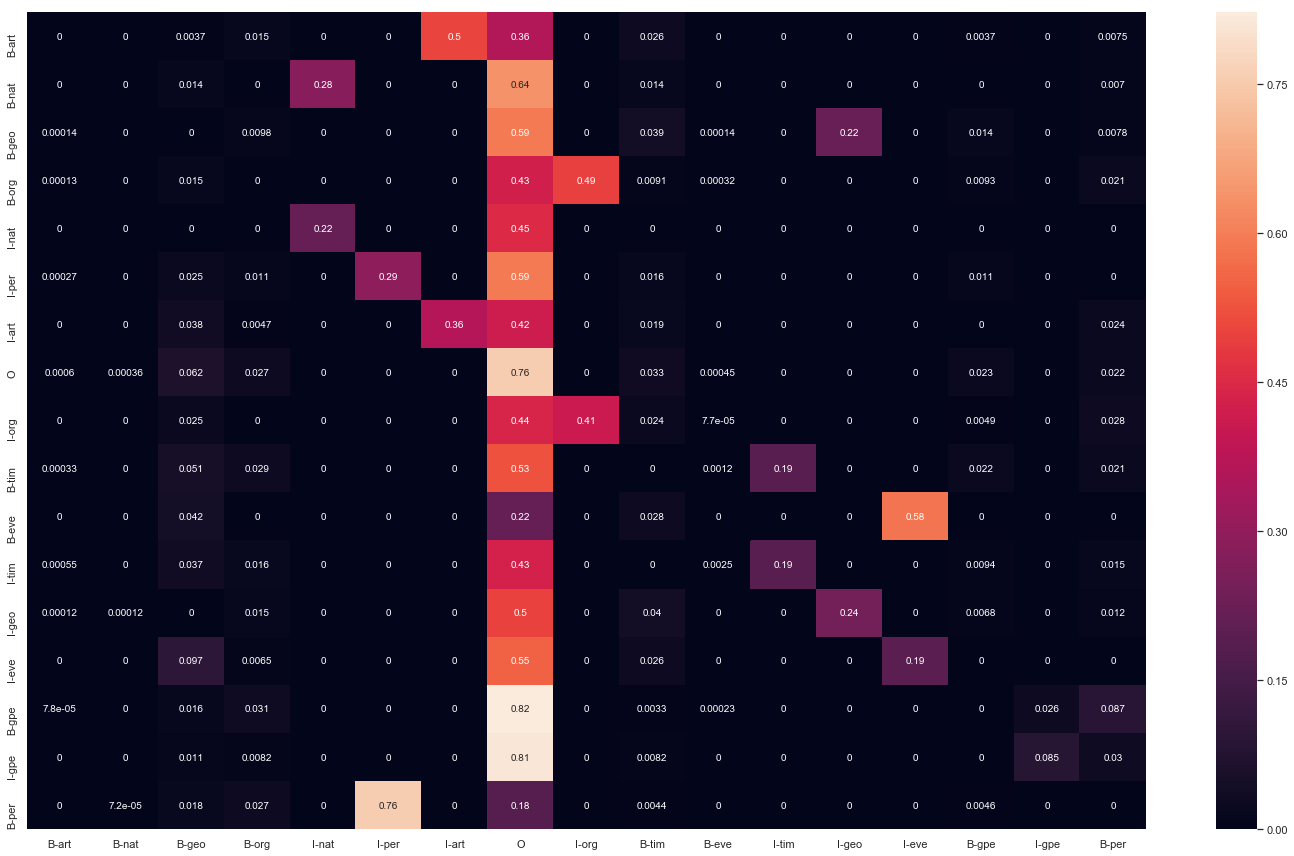

In [71]:
plt.figure(figsize=(20, 12))
sns.heatmap(A, annot=True, xticklabels=states, yticklabels=states, fmt='.2g')
plt.tight_layout()
plt.show()

### Step 2.4: Calculate emission probability (B)

In [72]:
words = list(set([word for sentence in X_train for word in sentence]))
words.append('unknown_word')
word2idx = {t: i for i, t in enumerate(words)}
idx2word = {i: w for w, i in word2idx.items()}

In [73]:
len(words)

22764

In [74]:
B = np.zeros((len(words), len(states)))
B_i = np.zeros(len(states))

In [75]:
for i in range(len(X_train)):
    if len(X_train[i]) > 0:
        for j in range(len(X_train[i])):
            B[
                word2idx[
                    X_train[i][j]
                ]
            ][
                tag2idx[
                    y_train[i][j]
                ]
            ] += 1
            B_i[tag2idx[y_train[i][j]]] += 1
for i in range(len(states)):
    B[:, i] = B[:, i] / B_i[i]

In [76]:
np.shape(pi)

(17,)

In [77]:
np.shape(A)

(17, 17)

In [78]:
np.shape(B.T)

(17, 22764)

## Step 3: Testing

### Step 3.1: Viterby implementation

In [79]:
def viterbi(pi, A, B, obs):
    nStates = np.shape(B)[0]
    T = np.shape(obs)[0]
    path = np.zeros(T)
    delta = np.zeros((nStates, T))
    phi = np.zeros((nStates, T))

    try:
        delta[:, 0] = pi * B[:, obs[0]]
        phi[:, 0] = 0
    except:
        print('\t', len(obs))

    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t - 1] * A[:, s]) * B[s, obs[t]]
            phi[s, t] = np.argmax(delta[:, t - 1] * A[:, s])

    path[T - 1] = np.argmax(delta[:, T - 1])
    for t in range(T - 2, -1, -1):
        #path[t] = phi[int(path[t+1]): int(t+1) , int(t+1)]
        path[t] = phi[int(path[t + 1]) , int(t + 1)]

    return path, delta, phi

### Step 3.2: Implementation testing

In [80]:
X_test_num = [[word2idx[word] if word in word2idx else word2idx['unknown_word'] for word in sentence] for sentence in X_test]

In [81]:
X_test_num = [sentence for sentence in X_test_num if len(sentence) > 0]

In [82]:
y_test = [sentence.tolist() for sentence in y_test if len(sentence) > 0]

In [83]:
y_pred = []
for sentence in X_test_num:
    path, _, _ = viterbi(pi, A, B.T, sentence)
    y_pred.append([idx2tag[step] for step in path])

In [84]:
crfsuite_report = crfsuite_classification_report(y_pred=y_pred, y_true=y_test)
print(crfsuite_report)

              precision    recall  f1-score   support

       B-art       0.00      0.61      0.01       142
       B-eve       0.14      0.21      0.17        97
       B-geo       0.73      0.63      0.68     14024
       B-gpe       0.63      0.65      0.64      6329
       B-nat       0.24      0.23      0.24        65
       B-org       0.75      0.54      0.63      7663
       B-per       0.82      0.64      0.72      6909
       B-tim       0.92      0.69      0.79      7352
       I-art       0.13      0.12      0.12       111
       I-eve       0.14      0.24      0.18        94
       I-geo       0.70      0.66      0.68      4178
       I-gpe       0.63      0.45      0.52       212
       I-nat       0.17      0.48      0.25        21
       I-org       0.65      0.54      0.59      6374
       I-per       0.81      0.73      0.77      7322
       I-tim       0.77      0.55      0.64      1863
           O       0.97      0.85      0.91    175267

   micro avg       0.79   

In [85]:
seqeval_report = seqeval_classification_report(y_pred=y_pred, y_true=y_test)
print(seqeval_report)

             precision    recall  f1-score   support

        tim       0.87      0.65      0.75      7352
        per       0.73      0.57      0.64      6909
        geo       0.70      0.60      0.65     14024
        gpe       0.63      0.65      0.64      6329
        org       0.63      0.45      0.53      7663
        eve       0.11      0.16      0.13        97
        nat       0.24      0.23      0.24        65
        art       0.00      0.38      0.00       142

avg / total       0.71      0.58      0.64     42581



# CRF

## Data reading

In [86]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/', 'subcorpus: Voice of America')

In [87]:
X = get_tagged_texts_as_pd(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

In [88]:
X.ner_tag.value_counts()

O          1032479
geo-nam      55480
org-nam      44646
per-nam      22931
gpe-nam      19685
tim-dow      11398
tim-dat      10929
per-tit       9672
per-fam       8098
[]            4064
tim-moy       3811
tim-yoc       3009
per-giv       2376
tim-clo        810
art-nam        789
eve-nam        514
nat-nam        280
tim-nam        132
eve-ord         63
per-ini         55
per-ord         35
org-leg         13
tim-dom          8
per-mid          1
art-add          1
Name: ner_tag, dtype: int64

In [89]:
X = filtrations(X, with_dots=True)

In [90]:
X.ner_tag.value_counts()

O        590495
B-geo     42533
B-org     23133
B-tim     22603
I-per     22211
B-per     20861
I-org     19332
B-gpe     19106
I-geo     12438
I-tim      5481
I-gpe       577
B-art       409
I-art       322
B-eve       310
I-eve       248
B-nat       208
I-nat        72
Name: ner_tag, dtype: int64

In [91]:
X = additional_features(X)

In [92]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780339 entries, 0 to 1231278
Data columns (total 17 columns):
token                       780339 non-null object
pos_tag                     780339 non-null object
lemma                       780339 non-null object
ner_tag                     780339 non-null object
word_net_sense_number       780339 non-null object
verb_net_roles              780339 non-null object
semantic_relation           780339 non-null object
animacy_tag                 780339 non-null object
super_tag                   780339 non-null object
lambda_dsr                  780339 non-null object
semantic_relation_tagged    780339 non-null int64
animacy_tagged              780339 non-null int64
lambda_dsr_len              780339 non-null int64
word_sense_exists           780339 non-null int64
is_title                    780339 non-null int64
contains_digits             780339 non-null int64
word_len                    780339 non-null int64
dtypes: int64(7), object(10)

In [94]:
X, y = crf_pre_processing(X)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [96]:
estimator = sklearn_crf(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=False)

In [97]:
scores = cross_val_score(estimator, X_train, y_train, cv=5, verbose=True, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


In [98]:
scores

array([0.97682903, 0.97806954, 0.97669285, 0.9776526 , 0.97740342])

In [99]:
estimator.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=False, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [100]:
y_pred = estimator.predict(X_test)

In [103]:
y_test = [sentence.tolist() for sentence in y_test]

## Testing

In [104]:
report = crfsuite_classification_report(y_pred=y_pred, y_true=y_test)
print(report)

              precision    recall  f1-score   support

       B-art       0.73      0.44      0.55       142
       B-eve       0.69      0.41      0.52        97
       B-geo       0.95      0.96      0.96     14024
       B-gpe       0.99      0.96      0.98      6329
       B-nat       0.93      0.63      0.75        65
       B-org       0.90      0.88      0.89      7663
       B-per       0.91      0.88      0.89      6909
       B-tim       0.97      0.95      0.96      7352
       I-art       0.71      0.63      0.67       111
       I-eve       0.64      0.24      0.35        94
       I-geo       0.94      0.96      0.95      4178
       I-gpe       0.86      0.60      0.71       212
       I-nat       0.88      0.67      0.76        21
       I-org       0.92      0.94      0.93      6374
       I-per       0.92      0.94      0.93      7322
       I-tim       0.88      0.91      0.90      1863
           O       0.99      0.99      0.99    175267

   micro avg       0.98   

In [105]:
seqeval_report = seqeval_classification_report(y_pred=y_pred, y_true=y_test)
print(seqeval_report)

             precision    recall  f1-score   support

        tim       0.95      0.94      0.95      7352
        per       0.88      0.85      0.86      6909
        geo       0.94      0.96      0.95     14024
        gpe       0.98      0.96      0.97      6329
        org       0.88      0.86      0.87      7663
        nat       0.93      0.63      0.75        65
        art       0.71      0.44      0.54       142
        eve       0.64      0.38      0.48        97

avg / total       0.93      0.92      0.92     42581



# Bi-LSTM

## Data reading

In [106]:
target_subcorpus_folders = filter_by_subcorpus('../data/datasets/gmb-2.2.0/', 'subcorpus: Voice of America')

In [107]:
X = get_tagged_texts_as_pd(target_subcorpus_folders, '../data/datasets/gmb-2.2.0/')

In [108]:
X.head(30)

,token,pos_tag,lemma,ner_tag,word_net_sense_number,verb_net_roles,semantic_relation,animacy_tag,super_tag,lambda_dsr
0,Thousands,NNS,thousand,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1001]:pred(v1,thousand,n..."
1,of,IN,of,O,0,[],O,O,(NP\NP)/NP,"lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(..."
2,demonstrators,NNS,demonstrator,O,1,[],O,Human,N,"lam(v1,b1:drs([],[b1:[1003]:pred(v1,demonstrat..."
3,have,VBP,have,O,0,[],O,O,(S[dcl]\NP)/(S[pt]\NP),"lam(v1,lam(v2,lam(v3,app(app(v1,v2),lam(v4,mer..."
4,marched,VBN,march,O,1,[Theme],O,O,S[pt]\NP,"lam(v1,lam(v2,app(v1,lam(v3,merge(b1:drs([b1:[..."
5,through,IN,through,O,0,[],O,O,((S[pt]\NP)\(S[pt]\NP))/NP,"lam(v1,lam(v2,lam(v3,lam(v4,app(app(v2,v3),lam..."
6,London,NNP,london,geo-nam,1,[],O,Place,N,"lam(v1,b1:drs([],[b1:[1007]:named(v1,london,ge..."
7,to,TO,to,O,0,[],O,O,(S[to]\NP)/(S[b]\NP),"lam(v1,lam(v2,lam(v3,merge(b1:drs([b1:[1008]:p..."
8,protest,VB,protest,O,1,"[Theme,Agent]",O,O,(S[b]\NP)/NP,"lam(v1,lam(v2,lam(v3,app(v2,lam(v4,app(v1,lam(..."
9,the,DT,the,O,0,[],O,O,NP/N,"lam(v1,lam(v2,alfa(def,merge(b1:drs([b1:[1010]..."


In [109]:
X.ner_tag.value_counts()

O          1032479
geo-nam      55480
org-nam      44646
per-nam      22931
gpe-nam      19685
tim-dow      11398
tim-dat      10929
per-tit       9672
per-fam       8098
[]            4064
tim-moy       3811
tim-yoc       3009
per-giv       2376
tim-clo        810
art-nam        789
eve-nam        514
nat-nam        280
tim-nam        132
eve-ord         63
per-ini         55
per-ord         35
org-leg         13
tim-dom          8
per-mid          1
art-add          1
Name: ner_tag, dtype: int64

In [110]:
X = filtrations(X, with_dots=True)

In [111]:
X.ner_tag.value_counts()

O        590495
B-geo     42533
B-org     23133
B-tim     22603
I-per     22211
B-per     20861
I-org     19332
B-gpe     19106
I-geo     12438
I-tim      5481
I-gpe       577
B-art       409
I-art       322
B-eve       310
I-eve       248
B-nat       208
I-nat        72
Name: ner_tag, dtype: int64

In [112]:
X.ner_tag.nunique()

17

In [113]:
X, y = SentenceExtractor().fit_transform(X)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [115]:
estimator = BiLSTMTagger(checkpoint_dir='../data/datasets/keras_model/')

In [116]:
estimator.fit(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            455320    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 489,960
Trainable params: 489,960
Non-trainable params: 0
_________________________________________________________________



Epoch 00001: val_loss improved from inf to 0.05665, saving model to ../data/datasets/keras_model/model.h5



Epoch 00002: val_loss improved from 0.05665 to 0.04224, saving model to ../data/datasets/keras_model/model.h5



Epoch 00003: val_loss improved from 0.04224 to 0.03295, saving model to ../data/datasets/keras_model/model.h5



Epoch 00004: val_loss improved from 0.03295 to 0.03007, saving model to ../data/datasets/keras_model/model.h5



Epoch 00005: val_loss improved from 0.03007 to 0.02893, saving model to ../data/datasets/keras_model/model.h5



In [117]:
y_pred = estimator.predict(X_test)

18725/18725 [==============================] - ETA: 4: - ETA: 1: - ETA: 1: - ETA: 48s - ETA: 41 - ETA: 37 - ETA: 34 - ETA: 31 - ETA: 28 - ETA: 27 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ET

In [118]:
y_test = [[estimator.tag2idx[w] for w in s] for s in y_test]
y_test = pad_sequences(maxlen=75, sequences=y_test, padding="post", value=estimator.tag2idx["O"])
y_test = [[estimator.idx2tag[w] for w in s] for s in y_test]

## Testing

In [119]:
crfsuite_report = crfsuite_classification_report(y_pred=y_pred, y_true=y_test)
print(crfsuite_report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       142
       B-eve       0.00      0.00      0.00        97
       B-geo       0.81      0.79      0.80     14024
       B-gpe       0.83      0.89      0.86      6329
       B-nat       0.00      0.00      0.00        65
       B-org       0.79      0.55      0.65      7663
       B-per       0.82      0.75      0.79      6909
       B-tim       0.90      0.85      0.88      7352
       I-art       0.00      0.00      0.00       111
       I-eve       0.00      0.00      0.00        94
       I-geo       0.79      0.72      0.75      4178
       I-gpe       0.66      0.63      0.64       212
       I-nat       0.00      0.00      0.00        21
       I-org       0.74      0.51      0.61      6374
       I-per       0.86      0.76      0.80      7322
       I-tim       0.77      0.66      0.71      1863
           O       0.99      1.00      1.00   1341619

   micro avg       0.99   

In [120]:
seqeval_report = seqeval_classification_report(y_pred=y_pred, y_true=y_test)
print(seqeval_report)

             precision    recall  f1-score   support

        org       0.72      0.50      0.59      7663
        per       0.71      0.64      0.67      6909
        geo       0.79      0.77      0.78     14024
        gpe       0.83      0.89      0.86      6329
        tim       0.86      0.81      0.84      7352
        eve       0.00      0.00      0.00        97
        nat       0.00      0.00      0.00        65
        art       0.00      0.00      0.00       142

avg / total       0.78      0.72      0.74     42581



# Conclusion

Итак, в данной работе были предприняты:
- простая попытка запомнить частоту тэгов для конкретных слов и выдача тэга с максимальной частотой для конкретного слова;
- попытка использовать какой-нибудь мульти-классификатор;
- попытка реализовать вариант скрытой марковской модели с использованием алгоритма Витерби для нахождения максимально вероятной цепочки скрытых состояний;
- попытка использовать CRF;
- попытка использовать двунаправленную LSTM.

Для корректного расчета метрик использовалась библиотека [seqeval](https://github.com/chakki-works/seqeval), она позволяет считать метрики с учетом особенностей многословных именованых сущностей.

Лучше всего на тесте себя показал CRF.